# NEMA Photoelectric

- Photoelectric interaction in PETALO

In [1]:
import Pkg

In [2]:
Pkg.add.(["HTTP", "Plots", "DataFrames", "HDF5","DrWatson", "StatsBase", "PhysicalConstants"]);

In [3]:
Pkg.add.(["Test"]);

In [4]:
Pkg.add.(["VegaLite","VegaDatasets"]);

In [5]:
Pkg.add.(["LsqFit","GLM"])

2-element Vector{Nothing}:
 nothing
 nothing

In [861]:
Pkg.add("Distributions") 

In [862]:
using Distributions

In [6]:
using LsqFit
using GLM

In [7]:
using HTTP
using Plots
using VegaLite
using VegaDatasets
using DataFrames
using HDF5
using DrWatson
using Test
using PhysicalConstants
using PhysicalConstants.CODATA2018
using Unitful

In [8]:
using Glob
using CSV

In [9]:
using Statistics
using StatsBase
using Printf

In [10]:
using Logging

In [11]:
@quickactivate "JPetalo"

In [12]:
pwd()

"/Users/jj/JuliaProjects/JPetalo/notebooks"

In [13]:
datadir()

"/Users/jj/JuliaProjects/JPetalo/data"

In [14]:
srcdir()

"/Users/jj/JuliaProjects/JPetalo/src"

In [1048]:
include(srcdir("jpetalo.jl"))

Main.JPetalo

In [16]:
import Unitful:
    nm, μm, mm, cm, m, km, inch, ft, mi,
    ac,
    mg, g, kg,
    Ra, °F, °C, K,
    rad, °,
    ns, μs, ms, ps, s, minute, hr, d, yr, Hz,
    eV,
    μJ, mJ, J,
	mW, μW, W,
    A, N, mol, mmol, V, L, mL, μL, M

In [17]:
function loglevel(log)
    if log == "Debug"
        logger = SimpleLogger(stdout, Logging.Debug)
    elseif log =="Info"
        logger = SimpleLogger(stdout, Logging.Info)
    else
        logger = SimpleLogger(stdout, Logging.Warn)
    end
    old_logger = global_logger(logger)
end

loglevel (generic function with 1 method)

# Characterization of PETALO

In [366]:
loglevel("Info")

Base.CoreLogging.SimpleLogger(IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(42) open, 0 bytes waiting))), Debug, Dict{Any, Int64}())

### Read a summary data frame with photoelectric interactions

In [1018]:
drx = datadir("nema3df")
input = string(drx,"/nemadf_f50_detconf_pde_03_sigmatof_85ps_kmeans_all.csv")
n3df = DataFrame(CSV.File(input));

In [1019]:
println(names(n3df))

["nsipm1", "nsipm2", "q1", "q2", "r1", "r1q", "r2", "r2q", "t1", "t2", "ta1", "ta2", "tr1", "tr2", "ux", "uy", "uz", "x1", "x2", "xb1", "xb2", "xr1", "xr2", "xs", "xt1", "xt2", "y1", "y2", "yb1", "yb2", "yr1", "yr2", "ys", "yt1", "yt2", "z1", "z2", "zb1", "zb2", "zr1", "zr2", "zs", "zt1", "zt2"]


## Dependence of energy with radius of interaction
- Histograming the energy deposited in the SiPMs yields a wide and non gaussian distribution
- The reason is that the energy deposited in the SiPMs depends of the radius at which the gamms interacted.
- The relation is roughly linear in a good range of radius, cannot be used for charge too low and saturates for charge too high
- This dependence can be used to define an estimator, "rq" of the radius of interaction

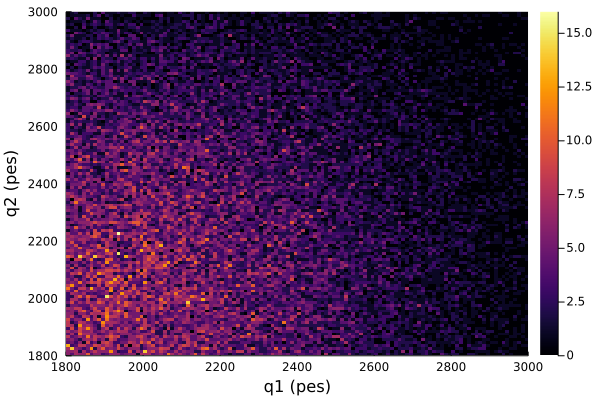

In [1020]:
xe,ye,hqr,phqr = JPetalo.hist2d(n3df.q1,n3df.q2, 150, "q1 (pes)", "q2 (pes)", 0., 10000., 0., 10000.)
plot(phqr, legend=false, fmt = :png)

In [1021]:
@info names(n3df)

┌ Info: ["nsipm1", "nsipm2", "q1", "q2", "r1", "r1q", "r2", "r2q", "t1", "t2", "ta1", "ta2", "tr1", "tr2", "ux", "uy", "uz", "x1", "x2", "xb1", "xb2", "xr1", "xr2", "xs", "xt1", "xt2", "y1", "y2", "yb1", "yb2", "yr1", "yr2", "ys", "yt1", "yt2", "z1", "z2", "zb1", "zb2", "zr1", "zr2", "zs", "zt1", "zt2"]
└ @ Main In[1021]:1


### R resolution

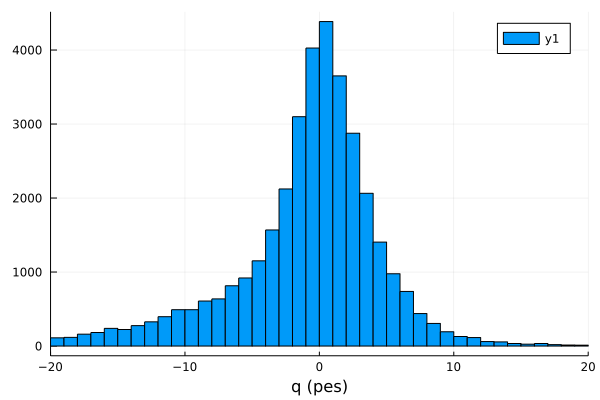

In [1051]:
hqc = JPetalo.hist1d(n3df.r1 - n3df.r1q, 50, -20., 20.)
phqc = plot(hqc, xlim=(-20., 20.), xlabel="q (pes)")

In [1043]:
fg = JPetalo.fit_gauss2(n3df.r1 - n3df.r1q, -15.0, 15.0);

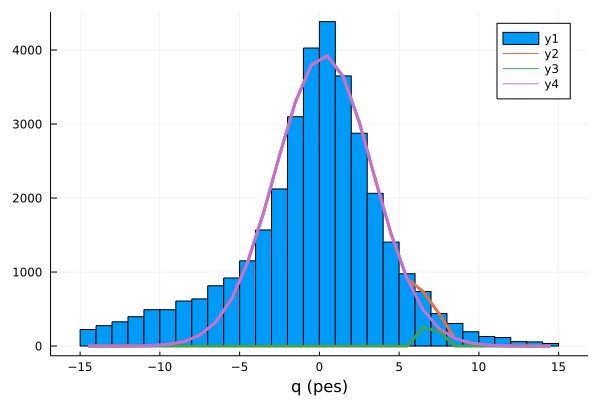

In [1046]:
phqc = plot(fg.h, xlabel="q (pes)")
p = plot!(phqc, fg.X, fg.Y, lw=3)
p = plot!(phqc, fg.X, fg.g[1].(fg.X), lw=3)
p = plot!(phqc, fg.X, fg.g[2].(fg.X), lw=3)

In [1039]:
@info "fit" fg.mu fg.std

┌ Info: fit
│   fg.mu = Number[6.9929990592648625, 0.29903607272668564]
│   fg.std = Number[0.18494050295912626, 3.040478251047203]
└ @ Main In[1039]:1


In [1049]:
fg = JPetalo.fit_gauss(n3df.r1 - n3df.r1q, -5.0, 5.0, 50);

In [1050]:
@info "fit" fg.mu fg.std

┌ Info: fit
│   fg.mu = Number[0.3459468178998603]
│   fg.std = Number[2.711882766790315]
└ @ Main In[1050]:1


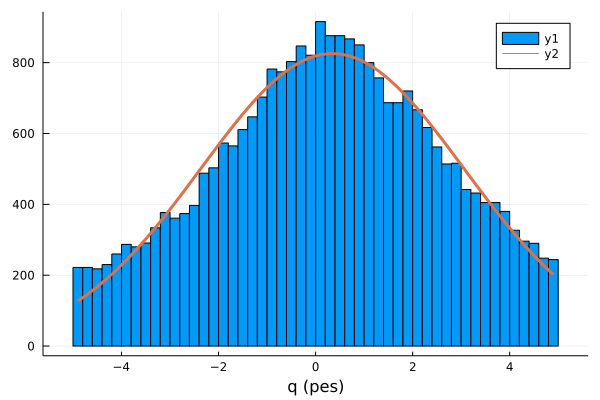

In [1054]:
phqc = plot(fg.h, xlabel="q (pes)")
p = plot!(phqc, fg.X, fg.Y, lw=3)

In [1056]:
@info " resolution (sigma) = $(fg.std) mm, FWHM = $(2.3 * fg.std) mm"

┌ Info:  resolution (sigma) = Number[2.711882766790315] mm, FWHM = [6.2373303636177235] mm
└ @ Main In[1056]:1


### Q vs R

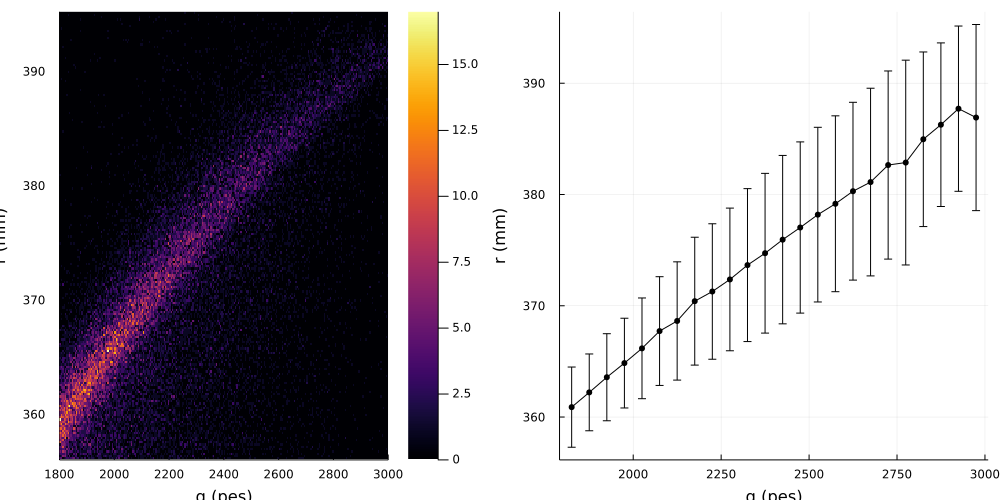

In [1057]:
xe,ye,hqr,phqr = JPetalo.hist2d(n3df.q1,n3df.r1, 250, "q (pes)", "r (mm)")
pqrdf = JPetalo.p1df(n3df.q1, n3df.r1, 25)
pp = plot(pqrdf.x_mean,pqrdf.y_mean, yerror=pqrdf.y_std, shape = :circle, color = :black, legend=false)
xlabel!("q (pes)")
ylabel!("r (mm)")
plot(phqr, pp, legend=false, size = (1000, 500), fmt = :png)

### Number of SiPMs with charge above threshold

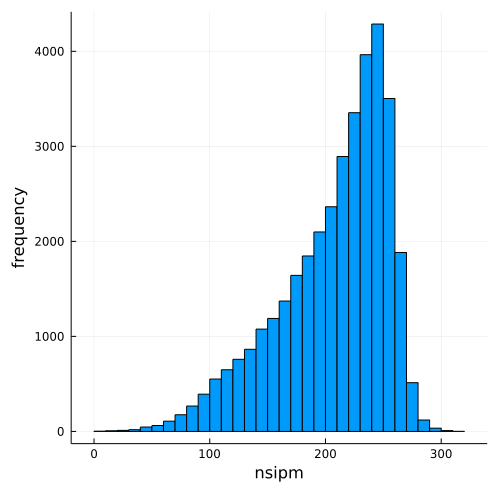

In [1058]:
hnsipm, pnsipm = JPetalo.hist1d(n3df.nsipm1,  "nsipm", 50);
plot(pnsipm,  layout = (1, 1), size = (500, 500), 
     legend=false, fmt = :png)

## Resolution in (x,y,z,r) intrinsic

In [1070]:
limxy = 15.0;

In [1071]:
hxtxr, pxtxr = JPetalo.hist1d(n3df.xt1 - n3df.x1, "xt - xr", 50,  -limxy, limxy);
plot(pxtxr,  layout = (1, 1), size = (500, 500), 
     legend=false, fmt = :png);

In [1072]:
hytyr, pytyr = JPetalo.hist1d(n3df.yt1 - n3df.y1, "yt - yr", 50,  -limxy, limxy);
plot(pytyr,  layout = (1, 1), size = (500, 500), 
     legend=false, fmt = :png);

In [1073]:
hztzr, pztzr = JPetalo.hist1d(n3df.zt1 - n3df.z1, "zt - zr", 50,  -limxy, limxy);
plot(pztzr,  layout = (1, 1), size = (500, 500), 
     legend=false, fmt = :png);

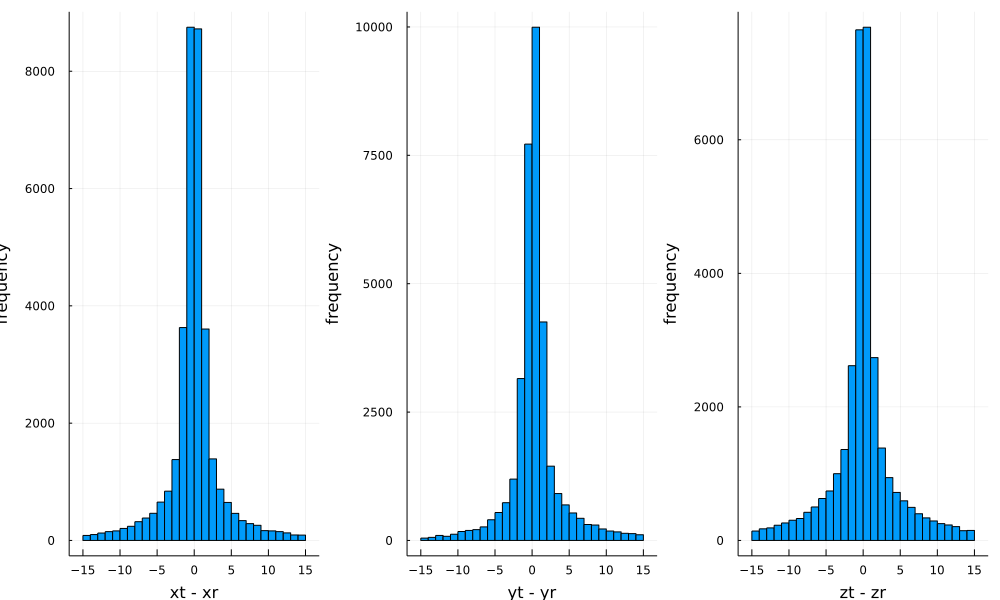

In [1074]:
plot(pxtxr, pytyr,pztzr, layout = (1, 3), size = (1000, 600), 
     legend=false, fmt = :png)

In [1075]:
xmu, xstd = JPetalo.mean_std(n3df.xt1 - n3df.x1, -2.0, 2.0)
@printf "Resolution in x (mm) = %5.1f" xstd

Resolution in x (mm) =   0.9

In [1076]:
xmu, xstd = JPetalo.mean_std(n3df.yt1 - n3df.y1, -2.0, 2.0)
@printf "Resolution in y (mm) = %5.1f" xstd

Resolution in y (mm) =   0.9

In [1077]:
xmu, xstd = JPetalo.mean_std(n3df.zt1 - n3df.zr1, -2.0, 2.0)
@printf "Resolution in y (mm) = %5.1f" xstd

Resolution in y (mm) =   0.9

In [983]:
@info " resolution (sigma) = $(fg.std) mm, FWHM = $(2.3 * fg.std) mm"

┌ Info:  resolution (sigma) = 0.8637214333106141 mm, FWHM = 1.9865592966144123 mm
└ @ Main In[983]:1


In [1082]:
fg = JPetalo.fit_gauss(n3df.xt1 - n3df.x1, -3.0, 3.0, 50);

In [1083]:
@info "fit" fg.mu fg.std

┌ Info: fit
│   fg.mu = Number[-0.006395412917521538]
│   fg.std = Number[1.113588946999531]
└ @ Main In[1083]:1


In [1084]:
@info " resolution (sigma) = $(fg.std) mm, FWHM = $(2.3 * fg.std) mm"

┌ Info:  resolution (sigma) = Number[1.113588946999531] mm, FWHM = [2.561254578098921] mm
└ @ Main In[1084]:1


In [1085]:
fg = JPetalo.fit_gauss(n3df.zt1 - n3df.z1, -3.0, 3.0, 50);

In [1086]:
@info " resolution (sigma) = $(fg.std) mm, FWHM = $(2.3 * fg.std) mm"

┌ Info:  resolution (sigma) = Number[0.9441657412787271] mm, FWHM = [2.1715812049410723] mm
└ @ Main In[1086]:1


## Resolution in xyz (r from q)

In [1087]:
limxy = 20.0;

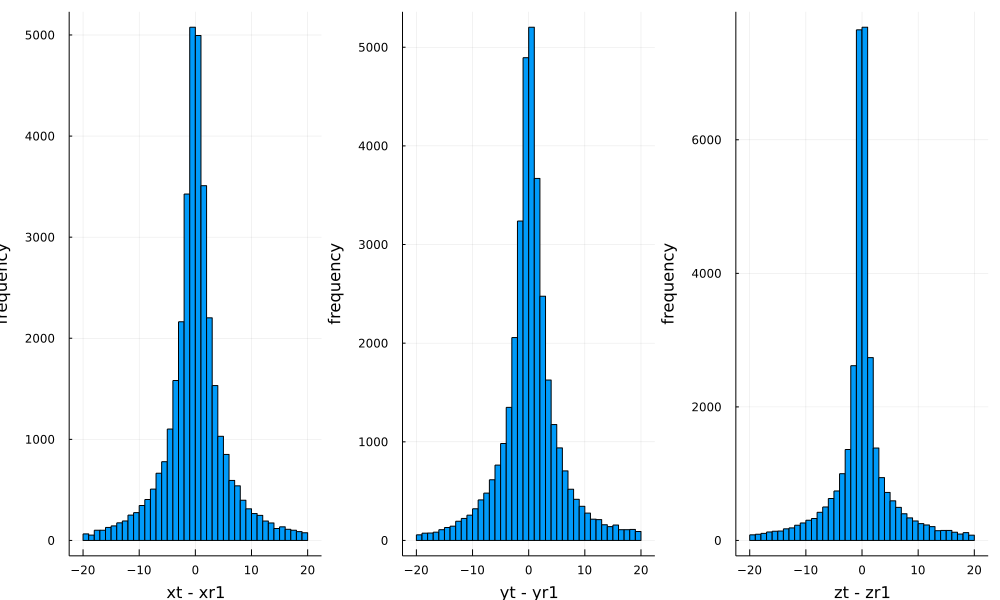

In [1088]:
hxtxr, pxtxr = JPetalo.hist1d(n3df.xt1 - n3df.xr1, "xt - xr1", 50,  -limxy, limxy);
plot(pxtxr,  layout = (1, 1), size = (500, 500), 
     legend=false, fmt = :png);
hytyr, pytyr = JPetalo.hist1d(n3df.yt1 - n3df.yr1, "yt - yr1", 50,  -limxy, limxy);
plot(pytyr,  layout = (1, 1), size = (500, 500), 
     legend=false, fmt = :png);
hztzr, pztzr = JPetalo.hist1d(n3df.zt1 - n3df.zr1, "zt - zr1", 50,  -limxy, limxy);
plot(pztzr,  layout = (1, 1), size = (500, 500), 
     legend=false, fmt = :png);
plot(pxtxr, pytyr,pztzr, layout = (1, 3), size = (1000, 600), 
     legend=false, fmt = :png)

In [1089]:
fg = JPetalo.fit_gauss(n3df.xt1 - n3df.xr1, -5.0, 5.0, 50);

In [1090]:
@info " resolution (sigma) = $(fg.std) mm, FWHM = $(2.3 * fg.std) mm"

┌ Info:  resolution (sigma) = Number[2.179404728630312] mm, FWHM = [5.012630875849717] mm
└ @ Main In[1090]:1


In [995]:
@info " resolution (sigma) = $(fg.std) mm, FWHM = $(2.3 * fg.std) mm"

┌ Info:  resolution (sigma) = 1.284491631080955 mm, FWHM = 2.9543307514861965 mm
└ @ Main In[995]:1


In [712]:
xmu, xstd = JPetalo.mean_std(n3dfxyz.xt1 - n3dfxyz.xr1, -5., 5.)
@printf "Resolution in x (mm) = %5.1f" xstd

Resolution in x (mm) =   3.0

## TOF

In [1094]:
c0 =uconvert(mm/ns, float(SpeedOfLightInVacuum))

299.792458 mm ns⁻¹

In [1095]:
cc = convert(Float32, c0/(mm*ns^-1))

299.79245f0

In [996]:
function ct12(df; reco=true)
    if reco
        return 1000.0*(df.tr1 - df.tr2)
    else
        return 1000.0 * (df.t1 - df.t2)
    end
end
        


ct12 (generic function with 1 method)

In [1096]:
function ctsr(df; reco=true)
    if reco
        tsr1 = [JPetalo.dxyz([df.xr1[i], df.yr1[i], df.zr1[i]], 
                             [df.xs[i], df.ys[i], df.zs[i]]) for i in 1:nrow(df)]/cc
        tsr2 = [JPetalo.dxyz([df.xr2[i], df.yr2[i], df.zr2[i]], 
                             [df.xs[i], df.ys[i], df.zs[i]]) for i in 1:nrow(df)]/cc
        
    else
        tsr1 = [JPetalo.dxyz([df.x1[i], df.y1[i], df.z1[i]], 
                             [df.xs[i], df.ys[i], df.zs[i]]) for i in 1:nrow(df)]/cc
        tsr2 = [JPetalo.dxyz([df.x2[i], df.y2[i], df.z2[i]], 
                             [df.xs[i], df.ys[i], df.zs[i]]) for i in 1:nrow(df)]/cc
    end
    return 1000.0*(tsr1 - tsr2)
end

ctsr (generic function with 1 method)

In [1102]:
function crb(df; reco=true)
    clxe = cc/1.6
    if reco
        trb1 = [JPetalo.dxyz([df.xr1[i], df.yr1[i], df.zr1[i]], 
                             [df.xb1[i], df.yb1[i], df.zb1[i]]) for i in 1:nrow(df)]/clxe;
        trb2 = [JPetalo.dxyz([df.xr2[i], df.yr2[i], df.zr2[i]], 
                             [df.xb2[i], df.yb2[i], df.zb2[i]]) for i in 1:nrow(df)]/clxe;
        
    else
        trb1 = [JPetalo.dxyz([df.x1[i], df.y1[i], df.z1[i]], 
                             [df.xb1[i], df.yb1[i], df.zb1[i]]) for i in 1:nrow(df)]/clxe;
        trb2 = [JPetalo.dxyz([df.x2[i], df.y2[i], df.z2[i]], 
                             [df.xb2[i], df.yb2[i], df.zb2[i]]) for i in 1:nrow(df)]/clxe;
     end
    return 1000.0*(trb1 - trb2)
end

crb (generic function with 1 method)

In [1126]:
t12 = ct12(n3df, reco=false);

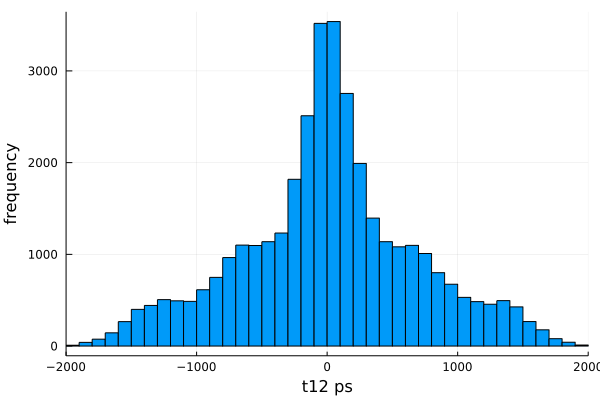

In [1127]:
ht1t2, pt1t2 = JPetalo.hist1d(t12, "t12 ps", 50,  -2000., 2000.)
plot(pt1t2, xlimit=(-2000.0,2000.0), legend=false)

In [1115]:
xmu, xstd = JPetalo.mean_std(t12, -200.0, 200.0)

(2.273650295566503, 109.61634664841817)

In [1128]:
tsr12 = ctsr(n3df, reco=false);

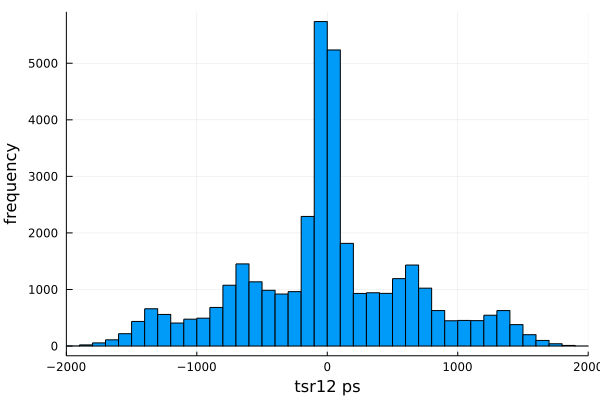

In [1129]:
htsr12, psr1t2 = JPetalo.hist1d(tsr12, "tsr12 ps", 50,  -2000., 2000.)
plot(psr1t2, xlimit=(-2000.0,2000.0),legend=false) 

In [1130]:
xmu, xstd = JPetalo.mean_std(tsr12, -200.0, 200.0)

(-6.445794327266624, 86.886956834582)

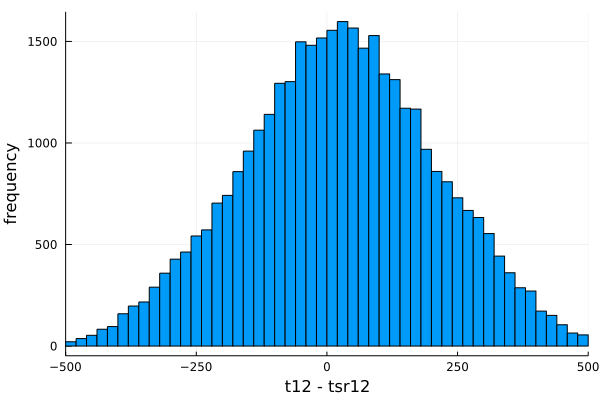

In [1131]:
h12, p12 = JPetalo.hist1d(t12-tsr12, "t12 - tsr12", 50,  -500., 500.)
plot(p12, xlimit=(-500.0,500.0),legend=false) 

In [1132]:
xmu, xstd = JPetalo.mean_std(t12-tsr12, -500.0, 500.0)

(22.948289958451173, 181.98216523423218)

In [1133]:
trb12 = crb(n3df, reco=false);

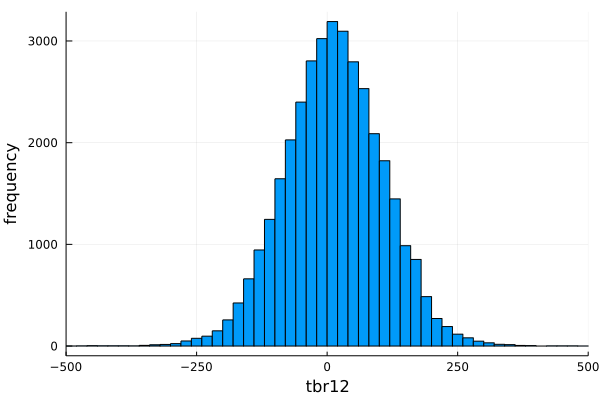

In [1134]:
htrb12, ptrb12 = JPetalo.hist1d(trb12, "tbr12", 50,  -500., 500.)
plot(ptrb12, xlimit=(-500.0,500.0), legend=false) 

In [1135]:
xmu, xstd = JPetalo.mean_std(trb12, -200.0, 200.0)

(11.491745303174081, 83.91420982091482)

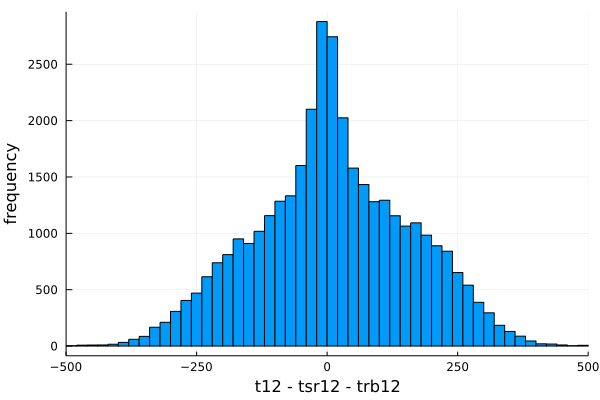

In [1136]:
h12, p12 = JPetalo.hist1d(t12 - tsr12 - trb12  , "t12 - tsr12 - trb12", 75,  -500., 500.)
p12 = plot(p12, xlimit=(-500.0,500.0), legend=false) 

In [1137]:
fg = JPetalo.fit_gauss(t12 - tsr12 - trb12, -250.0, 250.0, 50);
@info " resolution (sigma) = $(1000.0*fg.std) mm, FWHM = $(2.3 * 1000.0*fg.std) mm"

┌ Info:  resolution (sigma) = [103.01430139962883] mm, FWHM = [236.9328932191463] mm
└ @ Main In[1137]:2
